In [1]:
!pip install super-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install datasets

In [3]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.6 MB/s eta 0:00:00


In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch import nn
import numpy as np
from torchvision.models import vgg19
from torchmetrics import TotalVariation
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from datasets import load_dataset

import torchmetrics
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelSummary
from lightning.pytorch.tuner import Tuner

from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks import Callback
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.transforms import Normalize

import matplotlib.pyplot as plt
import multiprocessing
from collections import OrderedDict
from torchvision import datasets, transforms, utils
import torchvision

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
# https://pytorch-lightning.readthedocs.io/en/1.5.10/common/optimizers.html

In [6]:
class Div2KDataset(Dataset):
  def __init__(self,
               dataset_dict,
               upsampling_rate,
               patch_size,
               transform):
    super().__init__()
    self.dataset_dict = dataset_dict
    self.transform = transform
    self.low_r_transform = A.Compose([
        Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0), max_pixel_value=1.0), # [0, 1]
        A.Resize(patch_size//upsampling_rate, patch_size//upsampling_rate, cv2.INTER_CUBIC),
        ToTensorV2()
    ])

  def __getitem__(self, idx):
    high_r_y =  self.dataset_dict[idx]['hr']
    high_r_y = cv2.imread(high_r_y)
    high_r_y = cv2.cvtColor(high_r_y, cv2.COLOR_BGR2RGB)
    high_r_y  = self.transform(image=high_r_y)['image']
    low_r_x = (high_r_y.permute(1, 2, 0)).numpy()
    low_r_x =  self.low_r_transform(image=low_r_x)['image']
    return high_r_y, low_r_x

  def __len__(self):
    return len(self.dataset_dict)

In [7]:
# -------------------
# Step 2: Define train, validation, test data in DataModule
# -------------------

class DataModule(pl.LightningDataModule):
    def __init__(self,
                 upsampling_rate,
                 patch_size,
                 batch_size):
      super().__init__()
      self.upsampling_rate = upsampling_rate
      self.batch_size = batch_size
      self.patch_size = patch_size
      self.prepare_data()
      self.train_transform = A.Compose([
          A.RandomRotate90(p=0.75),
          A.HorizontalFlip(p=0.75),
          A.VerticalFlip(p=0.75),
          A.RandomCrop(patch_size, patch_size, p=1),
          Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [-1, 1]
          ToTensorV2()
      ])
      self.val_transform = A.Compose([
          A.CenterCrop(patch_size, patch_size, p=1),
          Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ToTensorV2()
      ])

    def prepare_data(self):
        self.train_dataset = load_dataset('eugenesiow/Div2k', 'bicubic_x4', split='train')
        self.val_dataset = load_dataset('eugenesiow/Div2k', 'bicubic_x4', split='validation')

    def setup(self, stage=None):
      self.train_data = Div2KDataset(self.train_dataset, self.upsampling_rate, self.patch_size, self.train_transform)
      self.val_data = Div2KDataset(self.val_dataset, self.upsampling_rate, self.patch_size, self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [8]:
# --------------------------------
# Step 2: Build your network
# --------------------------------
class Conv2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 strides=1,
                 padding='same',
                 dilation=1,
                 groups=1,
                 activation=nn.ReLU,
                 if_act=True,
                 if_batch_norm=True):
        super().__init__()
        layers = []
        if(if_batch_norm):
          bias = False
        else:
          bias = True
        conv2D = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=strides, padding=padding, dilation=dilation, groups=groups, bias=bias)
        batch_norm = nn.BatchNorm2d(out_channels)
        layers.append(conv2D)
        if(if_batch_norm):
            layers.append(batch_norm)
        if(if_act):
            layers.append(activation)
        self.convolution2D = nn.Sequential(*layers)

    def forward(self, x):
        return self.convolution2D(x)

In [9]:
############ SRGAN ############
class ResidualBlock(nn.Module):
  def __init__(self, in_channels):
    super(ResidualBlock, self).__init__()
    self.conv_act_bn_1 = Conv2D(in_channels=in_channels, out_channels=in_channels, kernel_size=(3, 3), activation=nn.PReLU())
    self.conv_act_bn_2 = Conv2D(in_channels=in_channels, out_channels=in_channels, kernel_size=(3, 3), activation=nn.PReLU(), if_act=False)

  def forward(self, x):
    residual = self.conv_act_bn_1(x)
    residual = self.conv_act_bn_2(residual)
    return residual + x

class UpsampleBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels):
    super(UpsampleBlock, self).__init__()
    conv_1 = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), if_act=False, if_batch_norm=False)
    pixel_shuffle = nn.PixelShuffle(2)
    activation = nn.PReLU()
    self.upsampling = nn.Sequential(*[conv_1, pixel_shuffle, activation])

  def forward(self, x):
    x = self.upsampling(x)
    return x

class SRGANGenerator(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               upsampling_rate):
    super(SRGANGenerator, self).__init__()
    self.first_res_conv = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=(9, 9), activation=nn.PReLU(), if_batch_norm=False)
    self.residual_seq = nn.Sequential(*[ResidualBlock(out_channels) for i in range(16)])
    self.last_res_conv = Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), if_act=False, if_batch_norm=True)
    self.upsampling_seq = nn.Sequential(*[UpsampleBlock(in_channels=out_channels, out_channels=(out_channels*upsampling_rate)) for i in range(upsampling_rate//2)])
    self.last_conv = Conv2D(in_channels=out_channels, out_channels=in_channels, kernel_size=(9, 9), activation=nn.PReLU(), if_batch_norm=False)
    self.activation = nn.Tanh()

  def forward(self, x):
    x = self.first_res_conv(x)
    new_x = self.residual_seq(x)
    new_x = self.last_res_conv(new_x) + x # long skip connection
    new_x = self.upsampling_seq(new_x)
    new_x = self.last_conv(new_x)
    new_x = self.activation(new_x)
    return new_x

class Discriminator(nn.Module):
  def __init__(self,
               in_channels,
               out_channels):
    super(Discriminator, self).__init__()
    layers=[]
    layers.append(Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), activation=nn.LeakyReLU(0.2), if_batch_norm=False))
    for i in range(6):
        if(i%2==0):
          layers.append(Conv2D(in_channels=out_channels, out_channels=out_channels*2, kernel_size=(3, 3), strides=2, padding=1, activation=nn.LeakyReLU(0.2)))
          out_channels = out_channels*2
        else:
          layers.append(Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), strides=1, activation=nn.LeakyReLU(0.2)))
    layers.append(Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), strides=2, padding=1, activation=nn.LeakyReLU(0.2)))
    layers.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features=out_channels, out_features=out_channels*2))
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.Linear(in_features=out_channels*2, out_features=1))
    layers.append(nn.Sigmoid())
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)

In [10]:
class FeaturesFromVGG19(nn.Module):
  def __init__(self,
               device):
    super().__init__()
    vgg = vgg19(pretrained=True).to(device)
    self.vgg = nn.Sequential(*list(vgg.features)[:-3]).eval() # using feature maps before activation (as the ESRGAN states it gets better results)
    for p in self.vgg.parameters():
      p.requires_grad = False
    self.normalize_input = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

  def forward(self, x):
    x = self.normalize_input(x)
    return self.vgg(x)

# Implements composite content+adversarial loss for our GAN
class SRGANLoss(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
        self.vgg = FeaturesFromVGG19(device)

    # Total Variation Loss (It is a regularization term used to encourage smoothness and reduce noise in the generated images)
    def total_variation_loss(self, x_fake):
      tv_loss = TotalVariation('mean').to(self.device)
      return tv_loss(x_fake)

    # L2 loss (used to encourage the generated samples to be close to the target samples)
    def mse_loss(self, x_real, x_fake):
      return F.mse_loss(x_real, x_fake)

    # Feature matching loss (Percepion loss)
    def vgg_loss(self, x_real, x_fake):
      return F.mse_loss(self.vgg(x_real), self.vgg(x_fake))

    # Adversarial loss
    def adversarial_loss(self, x, is_real):
      target = torch.zeros_like(x) if is_real else torch.ones_like(x)
      return F.binary_cross_entropy_with_logits(x, target)

    def forward(self, stage, generator, discriminator, g_optimizer, d_optimizer, manual_backward, hr_real, lr_real):
      # Calculating Loss for generator
      hr_fake = generator(lr_real)
      fake_preds_for_g = discriminator(hr_fake)
      g_loss = (0.001 * self.adversarial_loss(fake_preds_for_g, False) + 0.006 * self.vgg_loss(hr_real, hr_fake) + self.mse_loss(hr_real, hr_fake)) + 2e-8 * self.total_variation_loss(hr_fake)
      if(stage=='train'):
        # Optimizing generator
        g_optimizer.zero_grad()
        manual_backward(g_loss)
        g_optimizer.step()

      # Calculating Loss for discriminator
      fake_preds_for_d = discriminator(hr_fake.detach())
      real_preds_for_d = discriminator(hr_real.detach())
      d_loss = 0.5 * (self.adversarial_loss(real_preds_for_d, True) + self.adversarial_loss(fake_preds_for_d, False))
      if(stage=='train'):
        # Optimizing discriminator
        d_optimizer.zero_grad()
        manual_backward(d_loss)
        d_optimizer.step()
      return g_loss, d_loss, hr_fake

In [11]:
############ ESRGAN ############

class EUpsampleBlock(nn.Module):
    def __init__(self,
                 in_channels):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"),
                                      nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
                                      nn.LeakyReLU(0.2, inplace=True))
    def forward(self, x):
        return self.upsample(x)

class DenseResidualBlock(nn.Module):
  def __init__(self,
               in_channels,
               channels=32,
               residual_beta=0.2):
    super(DenseResidualBlock, self).__init__()
    self.residual_beta = residual_beta
    self.blocks = nn.ModuleList()

    for i in range(5):
      self.blocks.append(
          Conv2D(in_channels=in_channels + channels * i, out_channels=channels if i <= 3 else in_channels, kernel_size=(3, 3), activation=nn.LeakyReLU(0.2, inplace=True), if_act=True if i <=3 else False, if_batch_norm=False)
      )

  def forward(self, x):
    new_inputs = x
    for block in self.blocks:
      out = block(new_inputs)
      new_inputs = torch.cat([new_inputs, out], dim=1)
    return self.residual_beta * out + x

class BasicBlock(nn.Module):
  def __init__(self,
               in_channels,
               residual_beta = 0.2
               ):
    super(BasicBlock, self).__init__()
    self.residual_beta = residual_beta
    self.block = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

  def forward(self, x):
    return self.block(x) * self.residual_beta + x

class ESRGANGenerator(nn.Module):
  def __init__(self,
               in_channels=3,
               out_channels=64,
               upsampling_rate=4):
      super().__init__()
      self.first_res_conv = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), activation=nn.LeakyReLU(0.2, inplace=True), if_batch_norm=False)
      self.residual_seq = nn.Sequential(*[BasicBlock(out_channels) for i in range(23)])
      self.last_res_conv = Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), if_act=False, if_batch_norm=False)
      self.upsampling_seq = nn.Sequential(*[EUpsampleBlock(in_channels=out_channels) for i in range(upsampling_rate//2)])
      self.final = nn.Sequential(
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
      )
      self.activation = nn.Tanh()

  def forward(self, x):
      x = self.first_res_conv(x)
      new_x = self.residual_seq(x)
      new_x = self.last_res_conv(new_x) + x
      new_x = self.upsampling_seq(new_x)
      new_x = self.final(new_x)
      return self.activation(new_x)

In [12]:
# --------------------------------
# Step 3: Compile your model
# --------------------------------
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 learning_rate,
                 train_generator_only):
        super().__init__()
        self.generator = model['generator']
        self.discriminator = model['discriminator']
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.train_generator_only = train_generator_only
        if(train_generator_only==False):
          self.automatic_optimization = False
        self.save_hyperparameters(logger=False)

    def forward(self, x):
      pass

    def configure_optimizers(self):
      if(self.train_generator_only):
        gen_optimizer = self.optimizer(self.generator.parameters(), lr=self.learning_rate)
        return gen_optimizer
      else:
        self.gen_optimizer = self.optimizer(self.generator.parameters(), lr=self.learning_rate)
        self.dis_optimizer = self.optimizer(self.discriminator.parameters(), lr=self.learning_rate)
        return [self.gen_optimizer, self.dis_optimizer], []

    def training_step(self, batch, batch_idx):
      if(self.train_generator_only):
        loss, pred, y = self.common_step(batch, batch_idx, 'train')
        return loss
      else:
        g_loss, d_loss, pred, y = self.common_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
      if(self.train_generator_only):
          loss, pred, y = self.common_step(batch, batch_idx, 'val')
          return loss
      else:
          g_loss, d_loss, pred, y = self.common_step(batch, batch_idx, 'val')

    def common_step(self, batch, batch_idx, stage):

        if (stage == 'test') or (stage == 'val'):
            on_step = False
        else:
            on_step = True

        high_r_real, low_r_x = batch
        if(self.train_generator_only):
          self.high_r_fake = self.generator(low_r_x)
          loss = self.loss_function.mse_loss(high_r_real, self.high_r_fake)
          self.log(stage + '_generator_' + 'loss', loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
          return loss, self.high_r_fake, high_r_real
        else:
          g_loss, d_loss, self.high_r_fake = self.loss_function(stage, self.generator, self.discriminator, self.gen_optimizer, self.dis_optimizer, self.manual_backward, high_r_real, low_r_x)
          self.log(stage + '_generator_' + 'loss', g_loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
          self.log(stage + '_discriminator_' + 'loss', d_loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
          return g_loss, d_loss, self.high_r_fake, high_r_real

In [13]:
# -------------------
# Step 4: Init your DataModule
# -------------------

batch_size = 16
patch_size = 128
upsampling_rate = 4
data_module = DataModule(upsampling_rate=upsampling_rate, patch_size=patch_size, batch_size=batch_size)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset div2k downloaded and prepared to /root/.cache/huggingface/datasets/eugenesiow___div2k/bicubic_x4/2.0.0/d7599f94c7e662a3eed3547efc7efa52b2ed71082b40fc2e42a693870e35b677. Subsequent calls will reuse this data.


In [16]:
def fit(generator_model, train_generator_only=False, pretrained_generator_path=None, epochs=100, learning_rate=1e-5):
  device = 'cuda'

  if(generator_model=='SRGAN'):
    generator = SRGANGenerator(in_channels=3, out_channels=64, upsampling_rate=upsampling_rate)
    if(train_generator_only):
      generator_name_path = 'only_sr_resnet.pth'
    else:
      generator_name_path = 'srgan_generator.pth'

  if(generator_model=='ESRGAN'):
    generator = ESRGANGenerator(in_channels=3, out_channels=64, upsampling_rate=upsampling_rate)
    if(train_generator_only):
      generator_name_path = 'only_sr_dense_resnet.pth'
    else:
      generator_name_path = 'esrgan_generator.pth'

  if(pretrained_generator_path):
    generator.load_state_dict(torch.load(pretrained_generator_path))

  discriminator = Discriminator(in_channels=3, out_channels=64)
  gan = {'generator' : generator, 'discriminator' : discriminator}

  loss_function = SRGANLoss(device=device)
  optimizer = torch.optim.Adam
  learning_rate = learning_rate

  model = ModelCompilation(gan, loss_function, optimizer, learning_rate, train_generator_only=train_generator_only)
  trainer = pl.Trainer(precision='32', accelerator=device, devices="auto", max_epochs=epochs)
  trainer.fit(model, datamodule=data_module)
  # Saving generator
  torch.save(model.generator.state_dict(), generator_name_path)

In [15]:
fit(generator_model='ESRGAN', train_generator_only=False, pretrained_generator_path=None, epochs=330, learning_rate=0.00076)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.8MB/s] 


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Loading pretrained SRGAN generator
generator = SRGANGenerator(in_channels=3, out_channels=64, upsampling_rate=upsampling_rate)
generator.load_state_dict(torch.load('srgan_generator.pth'))

In [18]:
# Loading pretrained ESRGAN generator
generator = ESRGANGenerator(in_channels=3, out_channels=64, upsampling_rate=upsampling_rate)
generator.load_state_dict(torch.load('/kaggle/input/qweasd/esrgan_generator.pth', map_location='cpu'))

<All keys matched successfully>

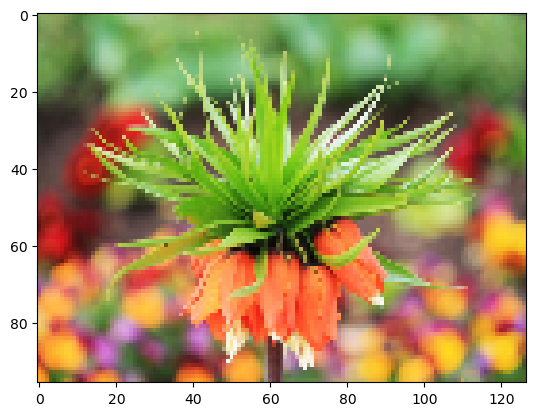

In [19]:
# Testing
low_r_real = cv2.imread(data_module.val_dataset[2]['lr'])
low_r_real = cv2.cvtColor(low_r_real, cv2.COLOR_BGR2RGB)
low_r_real = cv2.resize(low_r_real, (low_r_real.shape[1]//4, low_r_real.shape[0]//4), cv2.INTER_CUBIC)
cv2.imwrite('low_resolution.png', low_r_real)
plt.imshow(low_r_real)

low_r_real = torch.as_tensor(low_r_real).permute(2, 0, 1)/255

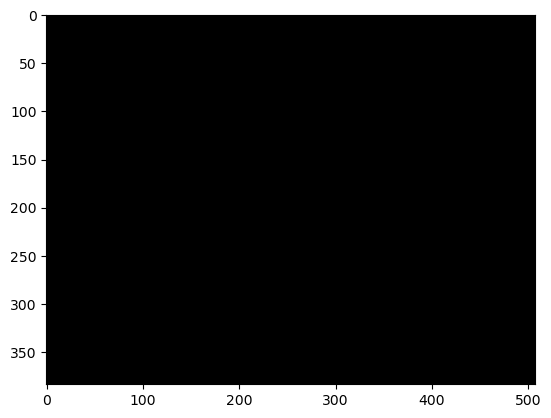

In [22]:
generator.eval()
high_r_fake = (generator(low_r_real[None, :])[0])
high_r_fake = high_r_fake.permute(1, 2, 0).detach().numpy()
high_r_fake = (high_r_fake + 1)/2
cv2.imwrite('high_resolution.png', cv2.cvtColor(high_r_fake*255, cv2.COLOR_BGR2RGB))
plt.imshow(high_r_fake)